<a href="https://colab.research.google.com/github/Rishabh-Bajpai/Child-Robot-Interaction/blob/master/MoveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.io
import numpy as np
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape, Dense,Cropping1D, advanced_activations
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras import losses
import cv2
import tqdm
from sklearn.model_selection import train_test_split
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
!mkdir data
!cp "/content/drive/My Drive/Phd/data/GAB01.mat" /content/data -v
!cp "/content/drive/My Drive/Phd/data/GAB02.mat" /content/data -v
!cp "/content/drive/My Drive/Phd/data/GAB03.mat" /content/data -v
!cp "/content/drive/My Drive/Phd/data/GAB04.mat" /content/data -v
!cp "/content/drive/My Drive/Phd/data/GAB05.mat" /content/data -v
!cp "/content/drive/My Drive/Phd/data/GAB06.mat" /content/data -v
!cp "/content/drive/My Drive/Phd/data/GAB07.mat" /content/data -v
!cp "/content/drive/My Drive/Phd/data/GAB08.mat" /content/data -v
!cp "/content/drive/My Drive/Phd/data/GAB09.mat" /content/data -v
!cp "/content/drive/My Drive/Phd/data/GAB10.mat" /content/data -v

'/content/drive/My Drive/Phd/data/GAB01.mat' -> '/content/data/GAB01.mat'
'/content/drive/My Drive/Phd/data/GAB02.mat' -> '/content/data/GAB02.mat'
'/content/drive/My Drive/Phd/data/GAB03.mat' -> '/content/data/GAB03.mat'
'/content/drive/My Drive/Phd/data/GAB04.mat' -> '/content/data/GAB04.mat'
'/content/drive/My Drive/Phd/data/GAB05.mat' -> '/content/data/GAB05.mat'
'/content/drive/My Drive/Phd/data/GAB06.mat' -> '/content/data/GAB06.mat'
'/content/drive/My Drive/Phd/data/GAB07.mat' -> '/content/data/GAB07.mat'
'/content/drive/My Drive/Phd/data/GAB08.mat' -> '/content/data/GAB08.mat'
'/content/drive/My Drive/Phd/data/GAB09.mat' -> '/content/data/GAB09.mat'
'/content/drive/My Drive/Phd/data/GAB10.mat' -> '/content/data/GAB10.mat'


In [ ]:
data = scipy.io.loadmat('/content/data/GAB01.mat')

In [ ]:
data.get("s0x8d10")

In [ ]:
np.shape(data["s0x8d10"]['cycles'][0][0][0]['left'][0]['time'][0][0])

(150, 47)

In [ ]:
data["s0x8d10"]['cycles'][0][0][0]['left'][0]['time'][0][0][149][45]

1.259999999999998

In [25]:
subject_train=['01','02','03','04','05','06','07','08','09']
subject_test=['10']
speed_train=['0x8','1','1x2']
speed_test=['0x8','1','1x2']
AOI_train=['d10','d7x5','d5','d2x5','i0','i2x5','i5','i7x5','i10']
AOI_test=['d10','d7x5','d5','d2x5','i0','i2x5','i5','i7x5','i10']
joint=['knee']
#full sample size is 13556
def datasizecounter (subject,speed,AOI,joint,side):
  #define a data matrix
  count=0
  for subID in subject:
    filename='GAB'
    filename=filename+subID+'.mat'
    for sp in speed:
      for angle in AOI:        
        tempData = scipy.io.loadmat('/content/data/'+filename)        
        #print(filename,'s'+sp+angle,np.shape(tempData['s'+sp+angle]['kinematics'][0][0][0]['jointangles'][0][side][0][0][joint[0]][0][0]['x'][0][0])[1])
        count+=np.shape(tempData['s'+sp+angle]['kinematics'][0][0][0]['jointangles'][0][side][0][0][joint[0]][0][0]['x'][0][0])[1]
        #print(np.shape(tempData['s'+sp+angle]['kinematics'][0][0][0]['jointangles'][0]["left"][0][0][joint][0][0]['x'][0][0]))
        #load data for subId,...,joint  line1
        #add the data to the data matrix  line1
  return(count)#data matrix)

def dataMatrixPicker (subject,speed,AOI,joint):
  #define a data matrix
  sizeL=datasizecounter (subject,speed,AOI,joint,'left')
  sizeR=datasizecounter (subject,speed,AOI,joint,'right')
  print(sizeL,sizeR)
  data=np.zeros((sizeL+sizeR,151))
  count=0
  currentInx=0
  for subID in subject:
    filename='GAB'
    filename=filename+subID+'.mat'
    for sp in speed:
      for angle in AOI:        
        tempData = scipy.io.loadmat('/content/data/'+filename)        
        print(filename,'s'+sp+angle,np.shape(tempData['s'+sp+angle]['kinematics'][0][0][0]['jointangles'][0]["left"][0][0][joint[0]][0][0]['x'][0][0])[1])
        count+=np.shape(tempData['s'+sp+angle]['kinematics'][0][0][0]['jointangles'][0]["left"][0][0][joint[0]][0][0]['x'][0][0])[1]
        data[currentInx:count,0:150]=np.transpose(tempData['s'+sp+angle]['kinematics'][0][0][0]['jointangles'][0]["left"][0][0][joint[0]][0][0]['x'][0][0])
        data[currentInx:count,150]=np.transpose(tempData['s'+sp+angle]['cycles'][0][0][0]['left'][0]['time'][0][0][149][0:count-currentInx])
        currentInx=count
        print(filename,'s'+sp+angle,np.shape(tempData['s'+sp+angle]['kinematics'][0][0][0]['jointangles'][0]["right"][0][0][joint[0]][0][0]['x'][0][0])[1])
        count+=np.shape(tempData['s'+sp+angle]['kinematics'][0][0][0]['jointangles'][0]["right"][0][0][joint[0]][0][0]['x'][0][0])[1]
        data[currentInx:count,0:150]=np.transpose(tempData['s'+sp+angle]['kinematics'][0][0][0]['jointangles'][0]["right"][0][0][joint[0]][0][0]['x'][0][0])
        data[currentInx:count,150]=np.transpose(tempData['s'+sp+angle]['cycles'][0][0][0]['right'][0]['time'][0][0][149][0:count-currentInx])        
        currentInx=count
  return(data)#data matrix)

training_data=dataMatrixPicker(subject_train,speed_train,AOI_train,joint)
testing_data=dataMatrixPicker(subject_test,speed_test,AOI_test,joint)

12038 12035
GAB01.mat s0x8d10 47
GAB01.mat s0x8d10 48
GAB01.mat s0x8d7x5 49
GAB01.mat s0x8d7x5 48
GAB01.mat s0x8d5 44
GAB01.mat s0x8d5 45
GAB01.mat s0x8d2x5 43
GAB01.mat s0x8d2x5 43
GAB01.mat s0x8i0 42
GAB01.mat s0x8i0 41
GAB01.mat s0x8i2x5 38
GAB01.mat s0x8i2x5 38
GAB01.mat s0x8i5 37
GAB01.mat s0x8i5 37
GAB01.mat s0x8i7x5 40
GAB01.mat s0x8i7x5 39
GAB01.mat s0x8i10 39
GAB01.mat s0x8i10 38
GAB01.mat s1d10 54
GAB01.mat s1d10 55
GAB01.mat s1d7x5 53
GAB01.mat s1d7x5 52
GAB01.mat s1d5 49
GAB01.mat s1d5 48
GAB01.mat s1d2x5 47
GAB01.mat s1d2x5 46
GAB01.mat s1i0 46
GAB01.mat s1i0 45
GAB01.mat s1i2x5 45
GAB01.mat s1i2x5 44
GAB01.mat s1i5 45
GAB01.mat s1i5 45
GAB01.mat s1i7x5 43
GAB01.mat s1i7x5 44
GAB01.mat s1i10 45
GAB01.mat s1i10 45
GAB01.mat s1x2d10 55
GAB01.mat s1x2d10 54
GAB01.mat s1x2d7x5 54
GAB01.mat s1x2d7x5 54
GAB01.mat s1x2d5 52
GAB01.mat s1x2d5 51
GAB01.mat s1x2d2x5 51
GAB01.mat s1x2d2x5 50
GAB01.mat s1x2i0 50
GAB01.mat s1x2i0 49
GAB01.mat s1x2i2x5 47
GAB01.mat s1x2i2x5 47
GAB01.mat 

In [26]:
import pickle
with open('trainingData', 'wb') as f:
    pickle.dump(training_data, f)
with open('testingData', 'wb') as f:
    pickle.dump(testing_data, f)

In [27]:
!cp '/content/trainingData' "/content/drive/My Drive/Phd/data/" -v
!cp '/content/testingData' "/content/drive/My Drive/Phd/data/" -v

'/content/trainingData' -> '/content/drive/My Drive/Phd/data/trainingData'
'/content/testingData' -> '/content/drive/My Drive/Phd/data/testingData'


In [ ]:
!cp "/content/drive/My Drive/Phd/data/trainingData" '/content/'  -v
!cp "/content/drive/My Drive/Phd/data/testingData" '/content/'  -v

'/content/drive/My Drive/Phd/data/trainingData' -> '/content/trainingData'
'/content/drive/My Drive/Phd/data/testingData' -> '/content/testingData'


In [67]:
with open('trainingData', 'rb') as f:
    training_data = pickle.load(f)
with open('testingData', 'rb') as f:
    testing_data = pickle.load(f)

In [68]:
vMean = np.mean(training_data[:,0:150],axis=1)[:, np.newaxis]
vStd = np.std(training_data[:,0:150],axis=1)[:, np.newaxis]
training_data[:,0:150]=(training_data[:,0:150]-vMean)/vStd
vMean = np.mean(testing_data[:,0:150],axis=1)[:, np.newaxis]
vStd = np.std(testing_data[:,0:150],axis=1)[:, np.newaxis]
testing_data[:,0:150]=(testing_data[:,0:150]-vMean)/vStd

array([[-1.41358505, -1.339471  , -1.2599678 , ..., -1.75091924,
        -1.72803726, -1.69802123],
       [-1.58735417, -1.55010847, -1.50794944, ..., -1.56838735,
        -1.53300939, -1.49237037],
       [-1.50350019, -1.45458557, -1.40095054, ..., -1.62460158,
        -1.59783293, -1.5637772 ],
       ...,
       [ 0.27931722,  0.30302124,  0.32742329, ...,  0.5032651 ,
         0.52198297,  0.54331381],
       [ 0.43438214,  0.45784876,  0.48195687, ...,  0.23312134,
         0.24247342,  0.25284255],
       [ 0.35948466,  0.37029222,  0.38124592, ...,  0.27400066,
         0.27463106,  0.27900741]])

In [69]:
training_data[24072,149]

0.2790074130536772

In [40]:
testing_data[3000:3033,150]

array([0.98, 0.95, 0.97, 0.98, 0.95, 0.96, 0.96, 0.95, 1.  , 0.99, 0.95,
       0.94, 0.97, 0.95, 0.97, 0.98, 0.96, 0.94, 0.96, 0.97, 0.96, 0.95,
       0.94, 0.96, 0.98, 0.96, 0.96, 0.97, 0.96, 0.96, 0.96, 0.97, 0.94])

In [70]:
np.sum(np.isnan(training_data))

0

In [75]:
np.shape(vMean)

0.007837730325227651

In [65]:
training_data[:,150] = training_data[:,150]
testing_data[:,150] = testing_data[:,150]

In [76]:
training_data=np.pad(training_data, [(0,0),(21,20)], mode='constant', constant_values=0)
testing_data=np.pad(testing_data, [(0,0),(21,20)], mode='constant', constant_values=0)

#training_data=np.pad(training_data, [(0,0),(4,9)], mode='constant', constant_values=0)
#testing_data=np.pad(testing_data, [(0,0),(4,)], mode='constant', constant_values=0)



In [43]:
print(np.shape(training_data))
print(np.shape(testing_data))

(24073, 192)
(3033, 192)


In [77]:
training_data = training_data.reshape((np.shape(training_data)[0],np.shape(training_data)[1], 1))
testing_data = testing_data.reshape(( np.shape(testing_data)[0], np.shape(training_data)[1], 1))

In [78]:
training_data[0,:,0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -1.41358505, -1.339471  , -1.2599678 , -1.17532477,
       -1.08594557, -0.99240999, -0.89534569, -0.79718739, -0.69982843,
       -0.60483171, -0.51369609, -0.4285598 , -0.35162913, -0.28243277,
       -0.22135895, -0.16861745, -0.12433018, -0.0904199 , -0.06396935,
       -0.04446212, -0.03135605, -0.02408835, -0.02300685, -0.02661583,
       -0.03398914, -0.04466482, -0.05820833, -0.07443979, -0.09293665,
       -0.11296709, -0.13426873, -0.15660096, -0.179754  , -0.2035718 ,
       -0.2276685 , -0.251891  , -0.27609592, -0.30014979, -0.32383006,
       -0.34701873, -0.36963493, -0.39157947, -0.41275017, -0.43288854,
       -0.45174415, -0.4693032 , -0.48539362, -0.49983182, -0.51

In [56]:
input_img = Input(shape=(192, 1))

x = Conv1D(32, 3, padding='same')(input_img)
x=(advanced_activations.LeakyReLU())(x)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, padding='same')(x)
x=(advanced_activations.LeakyReLU())(x)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(16, 3, padding='same')(x)
x=(advanced_activations.LeakyReLU())(x)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(8, 3, padding='same')(x)
x=(advanced_activations.LeakyReLU())(x)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(1, 3, padding='same')(x)
x=(advanced_activations.LeakyReLU())(x)
encoded = MaxPooling1D(2, padding='same')(x)

x = Conv1D(1, 3, padding='same')(encoded)
x=(advanced_activations.LeakyReLU())(x)
x = UpSampling1D(2)(x)
x = Conv1D(8, 3, padding='same')(x)
x=(advanced_activations.LeakyReLU())(x)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, padding='same')(x)
x=(advanced_activations.LeakyReLU())(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, padding='same')(x)
x=(advanced_activations.LeakyReLU())(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, padding='same')(x)
x=(advanced_activations.LeakyReLU())(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, padding='same', activation='linear')(x)
#decoded = Cropping1D(cropping=((9, 0)))(x)

autoencoder = Model(input_img, decoded)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')   #mean_squared_error    binary_crossentropy
autoencoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 192, 1)]          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 192, 32)           128       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 192, 32)           0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 96, 32)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 96, 32)            3104      
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 96, 32)            0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 48, 32)           

In [80]:
checkpointer = ModelCheckpoint(filepath='./moveNet.hdf5', verbose = 1, save_best_only = True) # verbose =1 is for printing the output
autoencoder.fit(training_data, training_data,epochs=30,batch_size=32,callbacks = [checkpointer],validation_split=0.2)
#autoencoder.fit(training_data, training_data,epochs=10,batch_size=32,validation_split=0.2)


Epoch 1/30
598/602 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 00001: val_loss improved from inf to 0.00814, saving model to ./moveNet.hdf5
602/602 [==============================] - 8s 12ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 2/30
598/602 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 00002: val_loss improved from 0.00814 to 0.00764, saving model to ./moveNet.hdf5
602/602 [==============================] - 7s 12ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 3/30
600/602 [============================>.] - ETA: 0s - loss: 0.0079
Epoch 00003: val_loss did not improve from 0.00764
602/602 [==============================] - 7s 12ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 4/30
601/602 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 00004: val_loss did not improve from 0.00764
602/602 [==============================] - 7s 12ms/step - loss: 0.0080 - val_loss: 0.0085
Epoch 5/30
598/602 [============================>.] - ETA: 0

In [ ]:
model.load_weights('/content/moveNet.hdf5')

In [ ]:
model.save_weights('/content/moveNet2.hdf5')

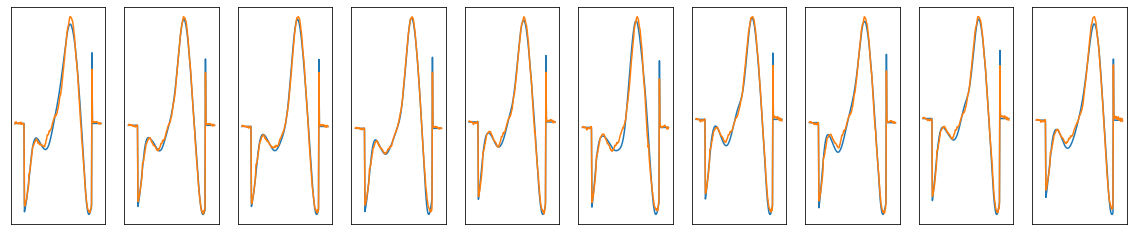

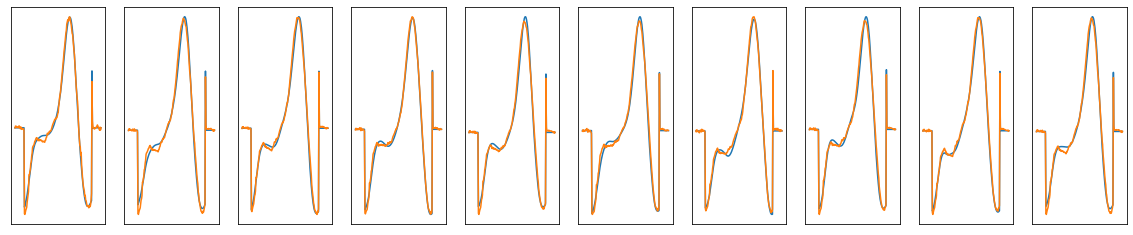

In [81]:
decoded_paths = autoencoder.predict(training_data)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,11):
    # display original
    ax = plt.subplot(1, n, i)
    plt.plot(np.squeeze(training_data[i]))
    plt.plot(np.squeeze(decoded_paths[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

decoded_paths = autoencoder.predict(testing_data)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,11):
    # display original
    ax = plt.subplot(1, n, i)
    plt.plot(np.squeeze(testing_data[i]))
    plt.plot(np.squeeze(decoded_paths[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


In [ ]:
decoded_paths = autoencoder.predict(testing_data)

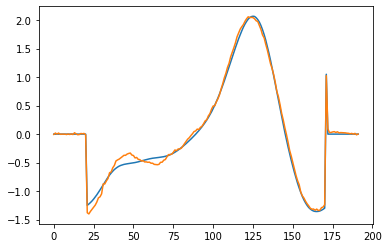

In [82]:
plt.plot(testing_data[0])
plt.plot(decoded_paths[0])

In [62]:
testing_data[0]

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-4.23909   ],
       [-3.83622826],
       [-3.38146738],
       [-2.87510517],
       [-2.29541356],
       [-1.65464638],
       [-0.96971395],
       [-0.2367026 ],
       [ 0.54331334],
       [ 1.34047948],
       [ 2.15012034],
       [ 2.95352537],
       [ 3.73160611],
       [ 4.4805104 ],
       [ 5.17744966],
       [ 5.80298322],
       [ 6.37264711],
       [ 6.88132631],
       [ 7.29007289],
       [ 7.64205705],
       [ 7.93906517],
       [ 8.16222893],
       [ 8.33682893],
       [ 8.47779336],
       [ 8